In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
obj_idx = 4
mesh_filename = os.path.join(model_dir,"obj_" + "{}".format(obj_idx+1).rjust(6, '0') + ".ply")
SCALING_FACTOR = 1.0/1000.0

In [4]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [5]:
object_poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 0.6, 0.6]),
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)  for angle in jnp.linspace(-jnp.pi, jnp.pi, 7)[:-1]])
observations = b.RENDERER.render_many(object_poses[:,None,...], jnp.array([0]))

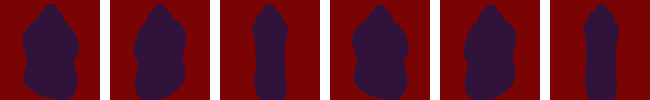

In [6]:
b.hstack_images([b.get_depth_image(o[...,2]) for o in observations])

In [7]:
grid = b.utils.make_translation_grid_enumeration_3d(
    -0.1, -0.1, -0.2,
    0.1, 0.1, 0.2,
    # 100, 100, 100
    60, 60, 60
)
b.show_cloud("grid", grid)

In [8]:
voxel_occupied_occluded_free_parallel = jax.jit(jax.vmap(b.utils.voxel_occupied_occluded_free, in_axes=(0, 0, None, None, None)))

In [9]:
occupancies = voxel_occupied_occluded_free_parallel(
    b.inverse_pose(object_poses), observations[...,2], grid, intrinsics, 0.001
)
print(occupancies.sum())

87440.0


In [10]:
b.clear()
b.show_cloud("grid", grid[(occupancies > 0.6).sum(0) > 0 ])
# b.show_cloud("grid2", grid[occupancy == 0.5],color=b.RED)

In [11]:
mesh = b.utils.make_voxel_mesh_from_point_cloud(grid[(occupancies > 0.6).sum(0) > 0 ], 0.01 )

In [12]:
b.clear()
b.show_trimesh("mesh", mesh)

In [13]:
from bayes3d.viz.open3dviz import Open3DVisualizer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [14]:
scaled_up_intrinsics = b.camera.scale_camera_parameters(intrinsics, 2)

In [15]:
viz = Open3DVisualizer(scaled_up_intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [16]:
distinct_colors = b.viz.distinct_colors(10)

In [17]:
viz.make_trimesh(mesh, jnp.eye(4),  jnp.array([*distinct_colors[0], 1.0]))

In [24]:
view_poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 0.9, 0.9]),
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)  for angle in jnp.linspace(-jnp.pi, jnp.pi, 100)[:-1]])

In [25]:
images = []
for p in tqdm(view_poses):
    images.append(viz.capture_image(intrinsics, b.inverse_pose(p)))

100%|█████████████████████████████████████| 99/99 [00:02<00:00, 33.05it/s]


In [26]:
b.viz.make_gif_from_pil_images([b.get_rgb_image(rgbd.rgb) for rgbd in images], "out.gif")

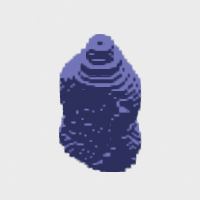

In [23]:
b.get_rgb_image(viz.capture_image(intrinsics, b.inverse_pose(view_poses[0])).rgb)